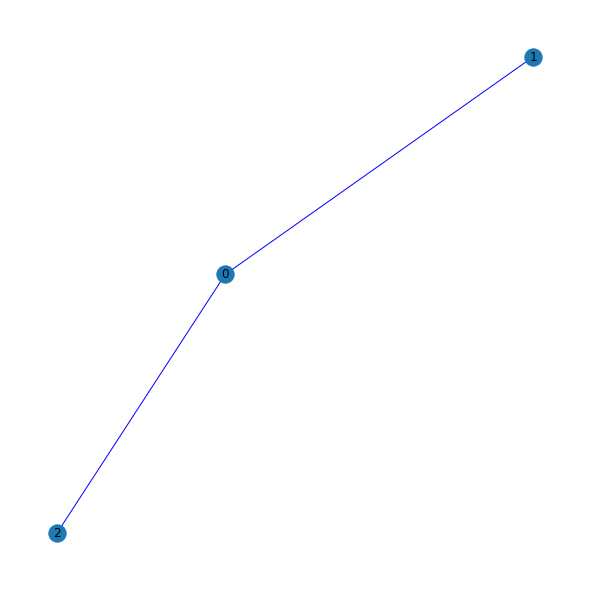

In [14]:
from pytket_dqc.circuits import DistributedCircuit
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
from pytket_dqc.networks import NISQNetwork
from pytket_dqc.placement import Placement
from pytket_dqc.distributors import Annealing
from pytket_dqc.packing import BipartiteCircuit
from pytket.passes import auto_rebase_pass
import json

circ = Circuit(2)
circ.CZ(0,1).Rx(3,0).CZ(0,1)
render_circuit_jupyter(circ)

dist_circ = DistributedCircuit(circ)

network = NISQNetwork([[0,1], [0,2]], {0:[0], 1:[1], 2:[2]})
network.draw_nisq_network()

distributor = Annealing()

placement = distributor.distribute(dist_circ, network)
assert dist_circ.is_placement(placement)

In [9]:
circ_with_dist = dist_circ.to_relabeled_registers(placement)
render_circuit_jupyter(circ_with_dist)

circ_with_dist = dist_circ.to_pytket_circuit(placement)
render_circuit_jupyter(circ_with_dist)

In [4]:
circ1 = Circuit(6)

circ1.CX(0, 3)
circ1.CX(1, 3)
circ1.CX(1, 4)
circ1.H(1)
circ1.CX(1, 5)
circ1.CX(2, 4)
circ1.CX(0, 3)
circ1.CX(0, 4)
circ1.H(3)
circ1.CX(0, 5)
circ1.X(0)
circ1.CX(0, 3)
render_circuit_jupyter(circ1)

gateset = {OpType.Rx, OpType.Rz, OpType.QControlBox, OpType.CZ}
custom = auto_rebase_pass(gateset)
custom.apply(circ1)

render_circuit_jupyter(circ1)

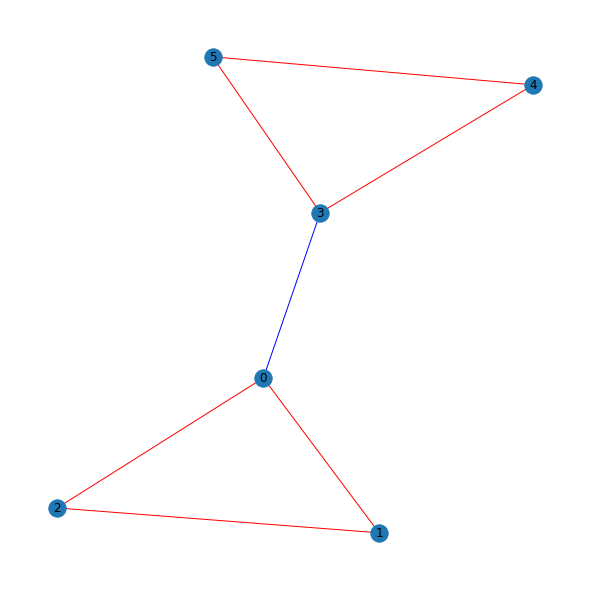

In [5]:
dist_circ1 = DistributedCircuit(circ1)

network1 = NISQNetwork([[0,1]], {0:[0,1,2], 1:[3,4,5]})
network1.draw_nisq_network()

placement1 = distributor.distribute(dist_circ1, network1)
assert dist_circ1.is_placement(placement1)

In [6]:
circ_with_dist1 = dist_circ1.to_relabeled_registers(placement1)
render_circuit_jupyter(circ_with_dist1)

circ_with_dist1_barriers = dist_circ1.to_pytket_circuit(placement1)
render_circuit_jupyter(circ_with_dist1_barriers)

In [10]:
import networkx as nx
bp_circ1 = BipartiteCircuit(circ_with_dist1,)
bp_graph1 = bp_circ1.get_bipartite_graph()
# print(bp_graph1.graph)
# print(bp_graph1.left_vertices)
# print(bp_graph1.right_vertices)
# print(bp_graph1.nx_graph)
# nx.draw_networkx(
#     bp_graph1.nx_graph,
#     pos = nx.drawing.layout.bipartite_layout(bp_graph1.nx_graph, bp_graph1.left_vertices),
#     node_color = '#ffeaee',
# )
print(bp_circ1.minimum_vertex_cover())

{0, 12, 7}


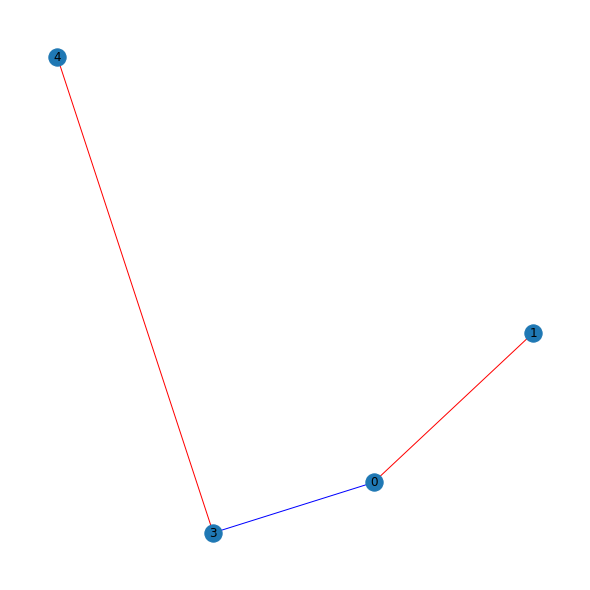

In [22]:
with open('examples/circuits/uccsd/raw/04_02_01.json') as f:
    circuit_s = json.load(f)
circ2 = Circuit.from_dict(circuit_s)


network2 = NISQNetwork([[0,1]], {0:[0,1], 1:[3,4]})
network2.draw_nisq_network()

In [23]:
custom.apply(circ2)
dist_circ2 = DistributedCircuit(circ2)

placement2 = distributor.distribute(dist_circ2, network2)
assert dist_circ2.is_placement(placement2)

In [24]:
circ_with_dist2 = dist_circ2.to_relabeled_registers(placement2)
render_circuit_jupyter(circ_with_dist2)

circ_with_dist2_barriers = dist_circ2.to_pytket_circuit(placement2)
render_circuit_jupyter(circ_with_dist2_barriers)

In [26]:
def ebit_cost(circ_with_barrier):
    count = 0
    for command in circ_with_barrier.get_commands():
        if command.op.type == OpType.CustomGate:
            count += 1
    
    return count / 2

ebit_cost(circ_with_dist2_barriers)

12.0